In [14]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from statsmodels.api import Logit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import seaborn as sns


from sklearn.linear_model import LinearRegression as lm
import statsmodels.formula.api as sm
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans,DBSCAN

# Step1. Meta 군집

In [15]:
df_meta = pd.read_csv("movie_meta_cleaned_final5.csv", engine="python")

### drop_columns : 군집 시 고려대상에서 제외할 변수들
- key가 되는 변수들 : movie_id, title, release_date
- dvd 관련 결측치 많은 변수들 : dvd_sales, blu_sales, total_sales, release_dvd, dvd_over_income
- inventory 관련 변수들 : item_id, inv_exist, contract_year, movie_down_sales, contract_price_inf, net_profit
- 이산 변수들 : mpa_rating, studio, prd_mthd
- 기타 : leg, blu

In [16]:
drop_columns = ["movie_id", "title", "release_date", "mpa_rating", "dvd_sales", "blu_sales", "total_sales", "legs", "src", "awards", "poster", "release_dvd",
               "prd_mthd", "item_id", "inv_exist", "contract_year","dvd_over_income", "movie_down_sales", "contract_price_inf", "inf", 
                "blu", "net_profit", "studio"]

dummy_columns = ["big_awards_num", "series_new", 'genre_action', 'genre_adventure',
       'genre_drama', 'genre_sci-fi', 'genre_fantasy', 'genre_thriller',
       'genre_animation', 'genre_family', 'genre_musical', 'genre_comedy',
       'genre_romance', 'genre_mystery', 'genre_war', 'genre_western',
       'genre_history', 'genre_sport', 'genre_horror', 'genre_crime',
       'genre_music', 'genre_biography', 'genre_documentary', 'english', 
        'dvd', 'cntry_USA', 'actor_A', 'actor_B', 'actor_C', 'director_A',
       'director_B', 'director_C', 'APPROVED', 'G', 'NC-17', 'NOT RATED',
       'PASSED', 'PG', 'PG-13', 'R', 'TV-14', 'TV-G', 'TV-MA', 'TV-PG',
       'TV-Y7']

In [17]:
df_meta_dropped = df_meta.drop(drop_columns, axis=1, inplace=False)
df_meta_dropped = df_meta_dropped.drop(dummy_columns, axis=1, inplace=False)
# df_meta_dropped : 분석 제외할 변수들, 더미변수 모두 제외한 df

In [18]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_meta_dropped)
df_scaled = pd.concat([pd.DataFrame(df_scaled),df_meta[dummy_columns]], axis=1)
df_scaled = np.array(df_scaled)
df_scaled # 더미 변수들 제외 scaling함

array([[ 0.56747942,  1.32604824,  0.17780286, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.8953069 ,  1.57451473,  0.8634114 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.1411775 ,  2.31991421,  2.03874031, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.05922063,  1.77328792, -0.40986159, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.05922063,  3.01562039, -2.36874311, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.05922063,  1.67390133,  0.37369102, ...,  0.        ,
         0.        ,  0.        ]])

In [19]:
df_scaled.shape

(4560, 71)

# PCA + Kmeans
* 주성분 분석을 통해 primary 변수들을 추출한 뒤, 그 기준으로 kmeans 군집 시행
* 고차원 데이터에서 군집을 분류해낼 수 있는 가장 기초적인 방법
* 보수적인 군집분석에서 가장 많이 사용하는 것이 PCA/SVD + K-means


## 1) PCA

In [20]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# 주성분 분석
from sklearn.decomposition import PCA
import statsmodels.api as sm

#### df_target : PCA 분석대상인 연속형 변수들만 남긴 데이터프레임 (df_meta_dropped)
* 결측치 많음/문자형 등으로 분석에 미포함하는 변수들 drop
* 더미변수 drop
* 총 columns 개수 : 26    

In [21]:
df_target=df_meta_dropped
df_target.head()

,release_year,runtime,imdb_score,share,inf_income_usa,theater_opening,theater_total,metascore,awards_win_num,awards_nomin_num,...,income_int,income_ww,positive_probability,inf_income_int,inf_income_ww,inf_budget,inf_income_opening,studio_score,price_class,contract_price
0,2011,136,6.6,23.053668,276934662.0,4155,4164,45.0,3,34,...,8.046000e+08,1.045664e+09,0.977014,9.243261e+08,1.201261e+09,4.353960e+08,1.035667e+08,6,1,650
1,2015,141,7.3,32.715702,496031246.0,4276,4276,66.0,8,55,...,9.440081e+08,1.403014e+09,0.861669,1.020156e+09,1.516187e+09,3.944425e+08,2.066999e+08,6,1,650
2,2018,156,8.5,33.139466,678815482.0,4474,4474,68.0,44,114,...,1.369544e+09,2.048360e+09,0.155046,1.369544e+09,2.048360e+09,3.000000e+08,2.576982e+08,6,10,920
3,2007,167,7.1,32.116864,409712211.0,4362,4362,50.0,20,64,...,6.540000e+08,9.634204e+08,0.876586,8.659796e+08,1.275692e+09,3.972384e+08,1.519209e+08,6,1,650
4,2017,121,6.4,34.915156,232544520.0,4051,4051,45.0,2,15,...,4.269209e+08,6.559452e+08,0.742135,4.334829e+08,6.660274e+08,3.046112e+08,9.528464e+07,6,1,650


In [22]:
scaler = StandardScaler()
nd_scaled = scaler.fit_transform(df_target)
df_scaled = pd.DataFrame(nd_scaled, columns=df_target.columns)
df_scaled.head().round(3)

,release_year,runtime,imdb_score,share,inf_income_usa,theater_opening,theater_total,metascore,awards_win_num,awards_nomin_num,...,income_int,income_ww,positive_probability,inf_income_int,inf_income_ww,inf_budget,inf_income_opening,studio_score,price_class,contract_price
0,0.567,1.326,0.178,-1.141,1.948,1.791,1.799,-0.529,-0.239,0.236,...,-0.086,-0.082,0.927,-0.078,-0.077,6.605,3.313,0.822,-0.442,-0.089
1,0.895,1.575,0.863,-0.811,4.054,1.881,1.887,0.642,0.034,0.680,...,-0.083,-0.076,0.611,-0.078,-0.075,5.898,7.290,0.822,-0.442,-0.089
2,1.141,2.320,2.039,-0.796,5.811,2.029,2.043,0.753,1.999,1.928,...,-0.076,-0.065,-1.323,-0.075,-0.072,4.268,9.256,0.822,3.426,3.286
3,0.240,2.867,0.668,-0.831,3.225,1.946,1.955,-0.250,0.689,0.871,...,-0.088,-0.084,0.652,-0.079,-0.076,5.946,5.177,0.822,-0.442,-0.089
4,1.059,0.581,-0.018,-0.736,1.522,1.713,1.709,-0.529,-0.294,-0.166,...,-0.092,-0.089,0.284,-0.081,-0.080,4.347,2.993,0.822,-0.442,-0.089


In [23]:
# 주성분 분석
# 일단 대략적으로 12개 columns 로 해보기
num = 12
pca = PCA(n_components=num)
nd_pca = pca.fit_transform(df_scaled)

lst_prin = []
for i in range(1,num+1):
    lst_prin.append("Prin" + str(i))

# 주성분 점수 저장
df_pca = pd.DataFrame(nd_pca, columns=lst_prin)
df_pca.shape

(4560, 12)

In [24]:
# 변수의 크기별 고유값과 누적비율을 비교해서 적용하며 스케일링을 했을 경우에는 고유값 기준을 본다.
# EigenValues > 1 을 기준으로 끊는다.

df_pca_stat = pd.DataFrame()
df_pca_stat['PrinNo'] = [i for i in range(1,num+1)]
df_pca_stat['EigenValues'] = pca.explained_variance_
df_pca_stat['EigenValueRatio'] = pca.explained_variance_ratio_
df_pca_stat['CumEigenValueRatio'] = np.cumsum(pca.explained_variance_ratio_)
df_pca_stat.round(3)

,PrinNo,EigenValues,EigenValueRatio,CumEigenValueRatio
0,1,7.414,0.285,0.285
1,2,4.215,0.162,0.447
2,3,3.432,0.132,0.579
3,4,1.759,0.068,0.647
4,5,1.410,0.054,0.701
5,6,1.081,0.042,0.743
6,7,0.946,0.036,0.779
7,8,0.924,0.036,0.814
8,9,0.810,0.031,0.846
9,10,0.791,0.030,0.876


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51452 missing from c

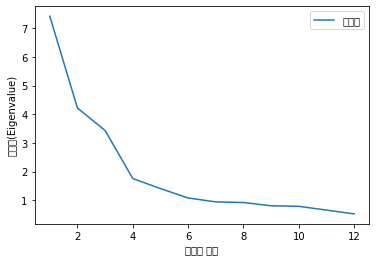

In [25]:
# 고유값을 그래프로 확인해보기

plt.plot(df_pca_stat["PrinNo"], df_pca_stat["EigenValues"], label="고유값")

plt.ylabel("고유값(Eigenvalue)")
plt.xlabel("주성분 번호")
plt.legend(loc="best")

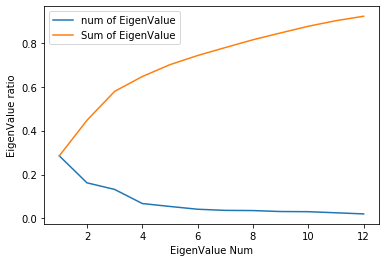

In [26]:
# 누적수치 또한 보면서 비교하기

plt.plot(df_pca_stat["PrinNo"], df_pca_stat["EigenValueRatio"], label="num of EigenValue")
plt.plot(df_pca_stat["PrinNo"], df_pca_stat["CumEigenValueRatio"], label="Sum of EigenValue")
plt.ylabel("EigenValue ratio")
plt.xlabel("EigenValue Num")
plt.legend(loc="best")

## 2) K-means
* df_meta_pca : PCA 통해서 채택된 변수들 & 빼놓았던 더미 변수들 merge한 최종 군집대상 데이터프레임
    - df_pca[lst_select_prim] : PCA 통해서 채택된 차원축소된 데이터프레임
    - df_meta[dummy_columns] : 기존 meta 더미변수들

In [28]:
select_num = 6

lst_select_prim = []
for i in range(1, select_num+1):
    lst_select_prim.append('Prin'+str(i))

In [29]:
df_meta_pca = pd.merge(df_pca[lst_select_prim], df_meta[dummy_columns], left_index = True, right_index = True, how = "left")

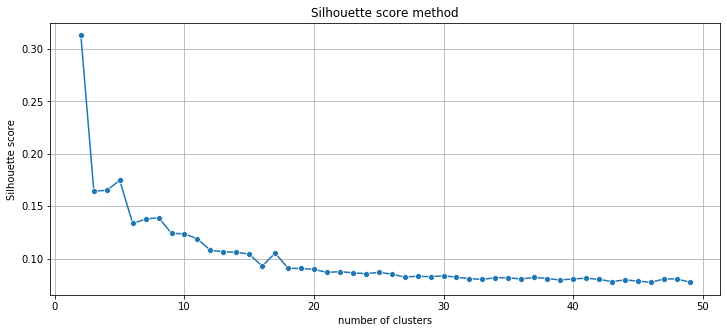

In [31]:
from sklearn.metrics import silhouette_score
n_clusters = range(2,50)
clusters_inertia = [] 
s_scores = []

for n in n_clusters:
    KM_est = KMeans(n_clusters=n, init='k-means++').fit(df_meta_pca)
    clusters_inertia.append(KM_est.inertia_)    # data for the elbow method
    silhouette_avg = silhouette_score(df_meta_pca, KM_est.labels_)
    s_scores.append(silhouette_avg)
    
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, s_scores, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
plt.grid()
plt.show()

# 여기 아래로는 캡처가 필요하다면 채은에게 알려주세요 

In [233]:
# 클러스터링 (K-means)
from sklearn.cluster import KMeans
import time

# 주성분 개수 고정
select_num = 6
num_clusters = 24

lst_select_prim = []
for i in range(1, select_num+1):
    lst_select_prim.append('Prin'+str(i))

# K means 
# category로 clustering 한 군집의 번호를 넣어줌
kmeans_clustering = KMeans(n_clusters=num_clusters)
idx = kmeans_clustering.fit_predict(df_meta_pca)
df_cluster = pd.DataFrame()
df_meta['cluster_kmeans'] = idx
df_meta.cluster_kmeans.value_counts()

3     439
7     348
12    337
13    325
20    321
23    311
1     300
11    294
17    271
10    235
19    226
18    195
6     194
9     146
15    146
21    132
0      77
2      72
8      66
5      57
16     39
22     18
4       8
14      3
Name: cluster_kmeans, dtype: int64

In [235]:
df_meta[(df_meta.inv_exist == 1)].cluster_kmeans.value_counts()

5     30
2     27
9     16
22    14
19     6
21     5
18     4
8      4
Name: cluster_kmeans, dtype: int64

## inventory의 군집
* inventory의 cluster 개수는 8개

In [236]:
df_inv = df_meta[df_meta["inv_exist"]==1]
df_inv["cluster_kmeans"].unique()

array([22,  5,  2, 18,  9,  8, 19, 21], dtype=int64)

In [237]:
df_inv["cluster_kmeans"].value_counts()

5     30
2     27
9     16
22    14
19     6
21     5
18     4
8      4
Name: cluster_kmeans, dtype: int64